# Convolution Neural Network for Data Autmentation Practice

## 1. Import the data

This tutorial uses the [tf_flowers](https://www.tensorflow.org/datasets/catalog/tf_flowers) dataset. For convenience, download the dataset using [TensorFlow Datasets](https://www.tensorflow.org/datasets). If you would like to learn about other ways of importing data, check out the [load images](https://www.tensorflow.org/tutorials/load_data/images) tutorial.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import layers

2024-12-25 06:24:13.616367: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-25 06:24:18.718964: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-25 06:24:20.557599: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-25 06:24:21.029428: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-25 06:24:24.580082: I tensorflow/core/platform/cpu_feature_guar

In [2]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

I0000 00:00:1735079144.438090    2147 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1735079149.164361    2147 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1735079149.164415    2147 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1735079149.178532    2147 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1735079149.178574    2147 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

In [3]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


Let's retrieve an image from the dataset and use it to demonstrate data augmentation.

2024-12-25 06:25:50.669767: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


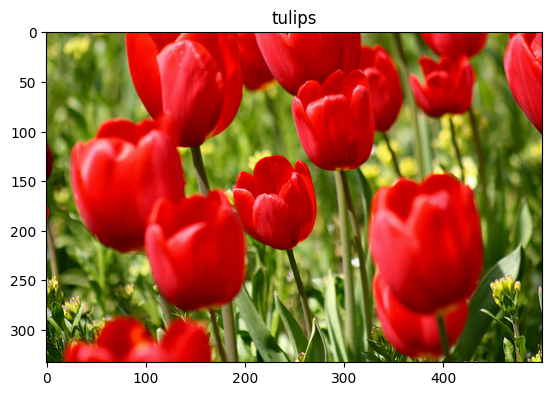

In [4]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

## 2. Use Keras preprocessing layers

### Resizing and rescaling

You can use the Keras preprocessing layers to resize your images to a consistent shape (with `tf.keras.layers.Resizing`), and to rescale pixel values (with `tf.keras.layers.Rescaling`).

In [5]:
from tensorflow.keras import layers

IMG_SIZE = 180

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])

Note: The rescaling layer above standardizes pixel values to the `[0, 1]` range. If instead you wanted it to be `[-1, 1]`, you would write `tf.keras.layers.Rescaling(1./127.5, offset=-1)`.

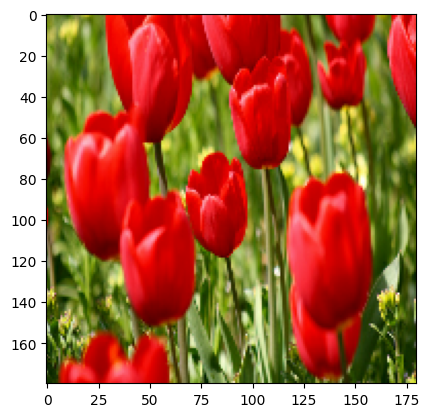

In [6]:
# You can visualize the result of applying these layers to an image. 
result = resize_and_rescale(image)
_ = plt.imshow(result)

In [7]:
# Verify that the pixels are in the `[0, 1]` range
print("Min and max pixel values:", result.numpy().min(), result.numpy().max())

Min and max pixel values: 0.0 1.0


## 3. Data augmentation

You can use the Keras preprocessing layers for data augmentation as well, such as `tf.keras.layers.RandomFlip` and `tf.keras.layers.RandomRotation`.

Let's create a few preprocessing layers and apply them repeatedly to the same image.

In [8]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [9]:
# Add the image to a batch.
image = tf.cast(tf.expand_dims(image, 0), tf.float32)

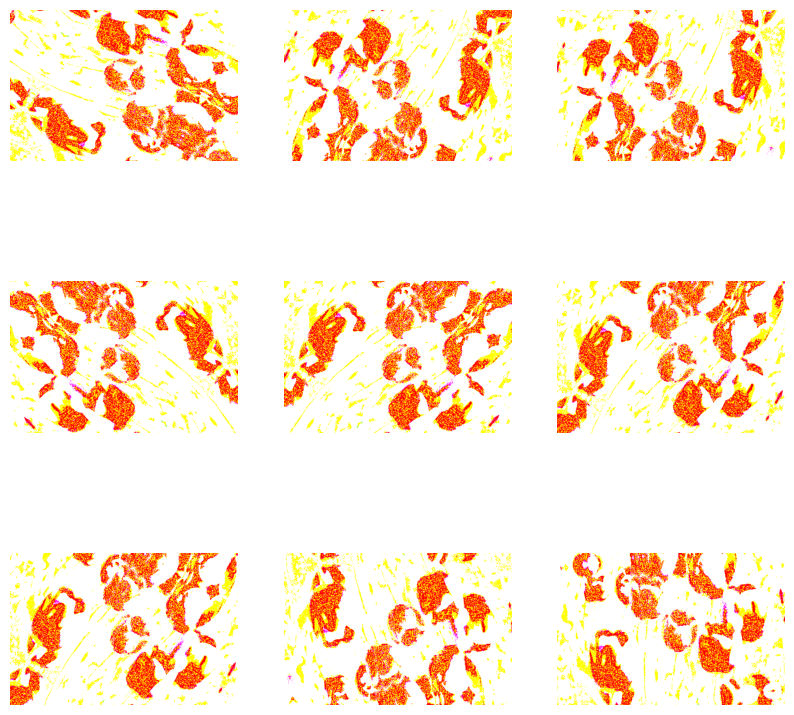

In [10]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

### Two options to use the Keras preprocessing layers

There are two ways you can use these preprocessing layers, with important trade-offs.

#### Option 1: Make the preprocessing layers part of your model

In [19]:
# model = tf.keras.Sequential([
#   # Add the preprocessing layers you created earlier.
#   resize_and_rescale,
#   data_augmentation,
#   layers.Conv2D(16, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   # Rest of your model.
# ])

There are two important points to be aware of in this case:

* Data augmentation will run on-device, synchronously with the rest of your layers, and benefit from GPU acceleration.

* When you export your model using `model.save`, the preprocessing layers will be saved along with the rest of your model. If you later deploy this model, it will automatically standardize images (according to the configuration of your layers). This can save you from the effort of having to reimplement that logic server-side.

Note: Data augmentation is inactive at test time so input images will only be augmented during calls to `Model.fit` (not `Model.evaluate` or `Model.predict`).

#### Option 2: Apply the preprocessing layers to your dataset

In [20]:
aug_ds = train_ds.map(lambda x, y: (resize_and_rescale(x, training=True), y))

With this approach, you use `Dataset.map` to create a dataset that yields batches of augmented images. In this case:

* Data augmentation will happen asynchronously on the CPU, and is non-blocking. You can overlap the training of your model on the GPU with data preprocessing, using `Dataset.prefetch`, shown below.
* In this case the preprocessing layers will not be exported with the model when you call `Model.save`. You will need to attach them to your model before saving it or reimplement them server-side. After training, you can attach the preprocessing layers before export.

You can find an example of the first option in the [Image classification](classification.ipynb) tutorial. Let's demonstrate the second option here.

### Apply the preprocessing layers to the datasets

Configure the training, validation, and test datasets with the Keras preprocessing layers you created earlier. You will also configure the datasets for performance, using parallel reads and buffered prefetching to yield batches from disk without I/O become blocking. (Learn more dataset performance in the [Better performance with the tf.data API](https://www.tensorflow.org/guide/data_performance) guide.)

Note: Data augmentation should only be applied to the training set.

In [21]:
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
  # Resize and rescale all datasets.
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
              num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets.
  ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

In [22]:
train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)